In [ ]:
!unzip /content/arabic_tweets.zip

In [ ]:
import numpy as np
import pandas as pd
data_dir = '/content/arabic_tweets'

In [ ]:
import tensorflow as tf 
tf.__version__

'2.12.0'

In [ ]:
# Set the batch size to 32
batch_size = 32

# Create a TensorFlow Keras text dataset for training using the data directory
# The data will be split into training and validation sets with a validation split of 0.2
# Only the training subset will be used to train the model
# The random seed is set to 1337 for reproducibility
raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    data_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    seed=1337,
)

raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    data_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    seed=1337,
)

Found 58751 files belonging to 2 classes.
Using 47001 files for training.
Found 58751 files belonging to 2 classes.
Using 11750 files for validation.


In [ ]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    data_dir, batch_size=batch_size
)

print(
    "Number of batches in raw_train_ds: %d"
    % tf.data.experimental.cardinality(raw_train_ds)
)
print(
    "Number of batches in raw_val_ds: %d" % tf.data.experimental.cardinality(raw_val_ds)
)
print(
    "Number of batches in raw_test_ds: %d"
    % tf.data.experimental.cardinality(raw_test_ds)
)

Found 58751 files belonging to 2 classes.
Number of batches in raw_train_ds: 1469
Number of batches in raw_val_ds: 368
Number of batches in raw_test_ds: 1836


In [ ]:
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(8):
        print(text_batch.numpy()[i].decode('utf-8').strip())
        print(label_batch.numpy()[i])
        print('--------------------------------')

لا مايردون الا بالتاق 😂
1
--------------------------------
على الأقل بعطل يومين مش زي بعض عالم 😏
0
--------------------------------
يخي ليتها العصر نبغى نفتك من التوتر والقلق 😩
0
--------------------------------
أستغفر الله العظيم وأتوب إليه. هنيئا للمستغفرين. لا شيء يعادل النية ال…
1
--------------------------------
إذ إنتي معي مشينا بس 😏
0
--------------------------------
صدق والله ولد هه والله حلوه كشته .. الله يحفظه من العين وشرها يارب 🙂
1
--------------------------------
انت لست صديقي القديم وإنما صديقي الذي لا يقدم ✨
1
--------------------------------
[شفشاون - المغرب] 💙 __ الحايك: "لباس المرأة في المغرب العربي، قطعة ثوب ترتديه يستر رأسها ووجه…
1
--------------------------------


In [ ]:
# Import the necessary libraries
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import string
import re

# Define a custom standardization function to preprocess the input data
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    return tf.strings.regex_replace(
        stripped_html, "[%s]" % re.escape(string.punctuation), ""
    )

# Define the maximum number of features, embedding dimension, and sequence length
max_features = 20000
embedding_dim = 128
sequence_length = 500

# Create a TextVectorization layer with the custom standardization function
# The maximum number of tokens is set to the maximum number of features
# The output mode is set to "int" to generate integer-encoded tokens
# The output sequence length is set to the sequence length
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode="int",
    output_sequence_length=sequence_length,
)

# Extract the text data from the training dataset
text_ds = raw_train_ds.map(lambda x, y: x)

# Adapt the TextVectorization layer to the text data to generate the vocabulary
vectorize_layer.adapt(text_ds)

In [ ]:
# Define a function to vectorize text and labels
def vectorize_text(text, label):
    # Expand the dimensions of the text tensor to match the input shape of the TextVectorization layer
    text = tf.expand_dims(text, -1)
    # Use the TextVectorization layer to vectorize the text and return the result along with the label
    return vectorize_layer(text), label

# Apply the vectorize_text function to the training, validation, and testing datasets
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

# Cache the datasets and prefetch data to improve performance
train_ds = train_ds.cache().prefetch(buffer_size=10)
val_ds = val_ds.cache().prefetch(buffer_size=10)
test_ds = test_ds.cache().prefetch(buffer_size=10)

In [ ]:
from tensorflow.keras import layers
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_features, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          1280000   
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        66048     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_ds, epochs=5,
                    validation_data=val_ds,
                    validation_steps=30)

Epoch 1/5


/usr/local/lib/python3.9/dist-packages/keras/backend.py:5703: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1469/1469 [==============================] - 129s 79ms/step - loss: 0.3434 - accuracy: 0.8397 - val_loss: 0.2053 - val_accuracy: 0.9219
Epoch 2/5
1469/1469 [==============================] - 78s 53ms/step - loss: 0.1416 - accuracy: 0.9494 - val_loss: 0.1899 - val_accuracy: 0.9312
Epoch 3/5
1469/1469 [==============================] - 77s 53ms/step - loss: 0.1024 - accuracy: 0.9651 - val_loss: 0.1895 - val_accuracy: 0.9354
Epoch 4/5
1469/1469 [==============================] - 79s 54ms/step - loss: 0.0804 - accuracy: 0.9740 - val_loss: 0.2238 - val_accuracy: 0.9219
Epoch 5/5
1469/1469 [==============================] - 78s 53ms/step - loss: 0.0678 - accuracy: 0.9791 - val_loss: 0.2549 - val_accuracy: 0.9187


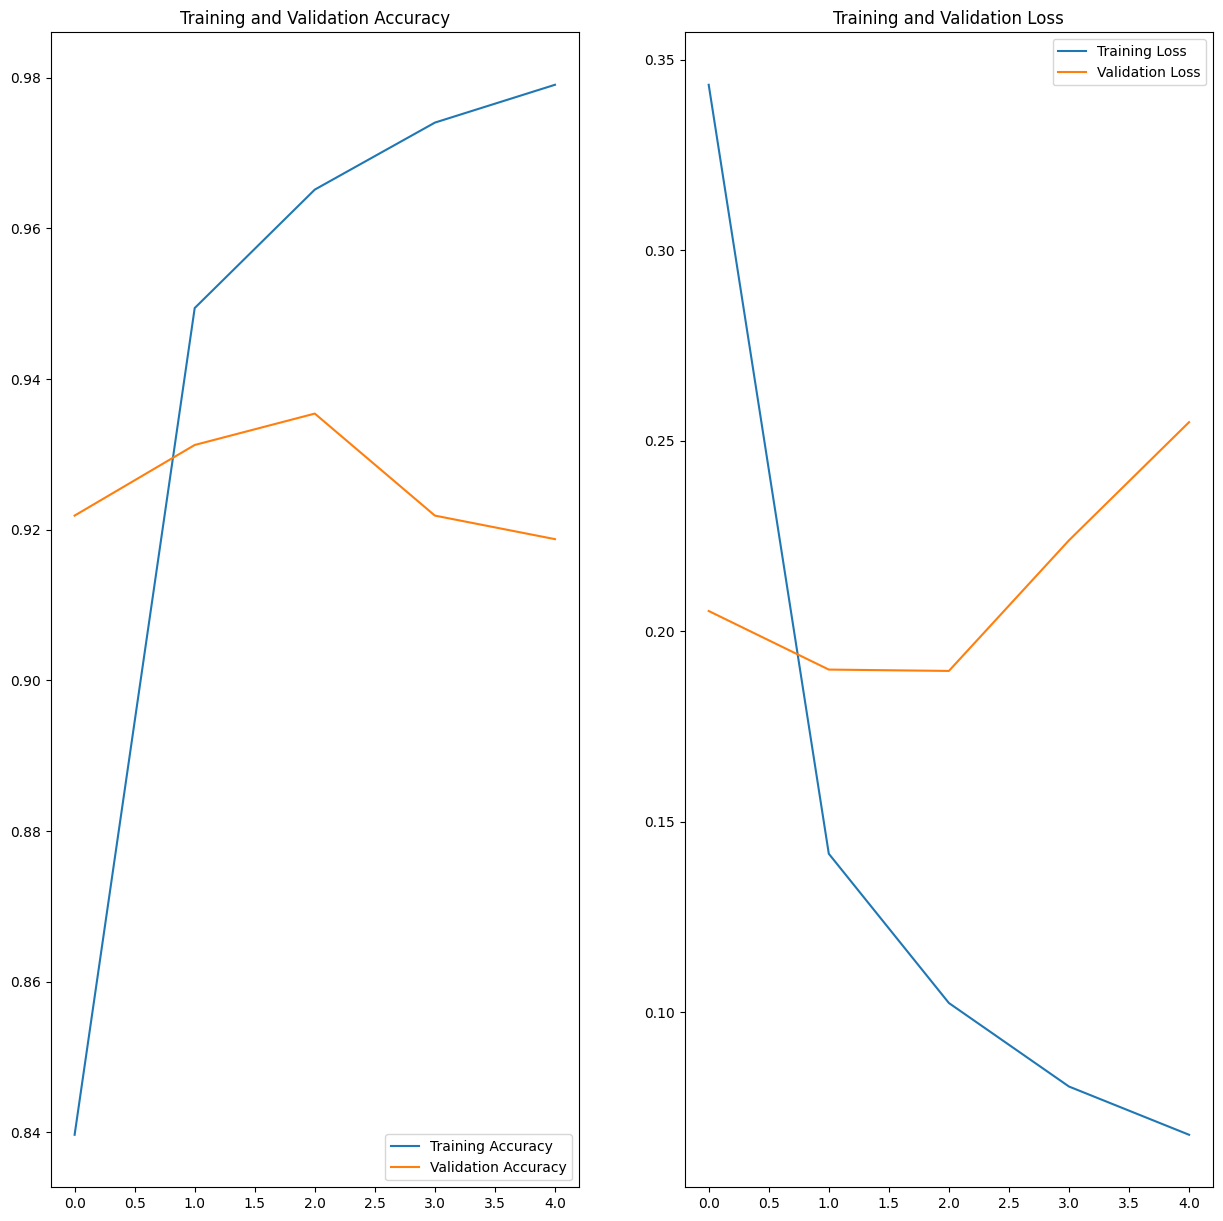

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']
plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(test_ds)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

1836/1836 [==============================] - 45s 25ms/step - loss: 0.0774 - accuracy: 0.9755
Test Loss: 0.07742132246494293
Test Accuracy: 0.975540816783905


In [ ]:
# Get the predicted labels for the first batch of the raw test dataset
for text_batch, label_batch in raw_test_ds.take(1):
    # Vectorize the text batch using the text vectorization layer
    text_batch_vectorized = vectorize_text(text_batch, label_batch)[0]

    # Get the predicted labels
    y_pred = model.predict(text_batch_vectorized)

    # Iterate over the text and label batches and print the text, true label, and predicted label
    for i in range(50):
        text = text_batch[i].numpy().decode('utf-8').strip()
        true_label = label_batch.numpy()[i]
        pred_label = 1 if y_pred[i] >= 0.6 else 0
        
        print('Text: {}\nTrue Label: {}\nPredicted Label: {}\n--------------------------------'.format(text, true_label, pred_label))


1/1 [==============================] - 2s 2s/step
Text: رسالة الدب 🐼 في الحلم يرمز الى رجل مخادع نواياه خبيثة قاسي القلب والطباع وممكن ان يكون ( نصاب ) 🔅 ثقة بان رسالة الح…
True Label: 1
Predicted Label: 1
--------------------------------
Text: يوما ما سينتهي هذا الخراب.. وستنبت هذه الارض عمارا من جديد 🌸❤ #سوريا 💔
True Label: 0
Predicted Label: 0
--------------------------------
Text: لاتتردوا اجمل وافضل وارقى ادااره 💐
True Label: 1
Predicted Label: 1
--------------------------------
Text: يارب إحفظه وأعده إلي سالم 💔
True Label: 0
Predicted Label: 0
--------------------------------
Text: مكاتب وخره 😭
True Label: 0
Predicted Label: 0
--------------------------------
Text: لان ليفربول سنوات في اليوربا ليغ هذا غير المرات اللي احتلوا فيها المركز الثامن والتاسع وصار الفريق بدون مشاركات…
True Label: 0
Predicted Label: 0
--------------------------------
Text: #وش_تعلمت_من_الدنياء انا اللي يكتب الدنيا دنياء لاترجي من وراه حكمه 😏
True Label: 1
Predicted Label: 0
--------------------------------

InvalidArgumentError: ignored

In [ ]:
model.save('final_model.h5')